# TensorFlow 2.0 教程-Transformer

这里我们将实现一个Transformer模型，将葡萄牙语翻译为英语。Transformer的核心思想是self-attention--通过关注序列不同位置的内容获取句子的表示。

Transformer的一些优点：
- 不受限于数据的时间/空间关系
- 可以并行计算
- 远距离token的相互影响不需要通过很长的时间步或很深的卷积层
- 可以学习远程依赖

Transformer的缺点：
- 对于时间序列，输出需要根据整个历史，而不是当前状态和输入，可能造成效率较低
- 如果想要获取时间空间信息，需要额外的位置编码



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
# 安装tfds pip install tfds-nightly==1.0.2.dev201904090105
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow.keras.layers as layers

import time
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)



2.0.0-alpha0


## 1.数据输入pipeline
我们将使用到Portugese-English翻译数据集。

该数据集包含大约50000个训练样例，1100个验证示例和2000个测试示例。


In [2]:

examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                              as_supervised=True)

将数据转化为subwords格式

In [3]:
train_examples, val_examples = examples['train'], examples['validation']

In [4]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
(en.numpy() for pt, en in train_examples), target_vocab_size=2**13)
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
(pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

token转化测试

In [5]:
sample_str = 'hello world, tensorflow 2'
tokenized_str = tokenizer_en.encode(sample_str)
print(tokenized_str)
original_str = tokenizer_en.decode(tokenized_str)
print(original_str)

[3222, 439, 150, 7345, 1378, 2824, 2370, 7881]
hello world, tensorflow 2


添加start、end的token表示

In [6]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
        lang1.numpy()) + [tokenizer_pt.vocab_size+1]
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        lang2.numpy()) + [tokenizer_en.vocab_size+1]
    return lang1, lang2
    

过滤长度超过40的数据

In [7]:
MAX_LENGTH=40
def filter_long_sent(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                         tf.size(y) <= max_length)

将python运算，转换为tensorflow运算节点

In [8]:
def tf_encode(pt, en):
    return tf.py_function(encode, [pt, en], [tf.int64, tf.int64])


### 构造数据集

In [9]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

# 使用.map()运行相关图操作
train_dataset = train_examples.map(tf_encode)
# 过滤过长的数据
train_dataset = train_dataset.filter(filter_long_sent)
# 使用缓存数据加速读入
train_dataset = train_dataset.cache()
# 打乱并获取批数据
train_dataset = train_dataset.padded_batch(
BATCH_SIZE, padded_shapes=([40], [40]))  # 填充为最大长度-90
# 设置预取数据
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 验证集数据
val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_long_sent).padded_batch(
BATCH_SIZE, padded_shapes=([40], [40]))



In [10]:
de_batch, en_batch = next(iter(train_dataset))
de_batch, en_batch

(<tf.Tensor: id=311363, shape=(64, 40), dtype=int64, numpy=
 array([[8214,  116,   84, ...,    0,    0,    0],
        [8214,    7,  261, ...,    0,    0,    0],
        [8214,  155,   39, ...,    0,    0,    0],
        ...,
        [8214,  639,  590, ...,    0,    0,    0],
        [8214,  204, 3441, ...,    0,    0,    0],
        [8214,   27,   13, ...,    0,    0,    0]])>,
 <tf.Tensor: id=311364, shape=(64, 40), dtype=int64, numpy=
 array([[8087,   83,  145, ...,    0,    0,    0],
        [8087, 4670, 1783, ...,    0,    0,    0],
        [8087,  169,   56, ...,    0,    0,    0],
        ...,
        [8087,  174,   79, ...,    0,    0,    0],
        [8087,   11,   16, ...,    0,    0,    0],
        [8087,    4,   12, ...,    0,    0,    0]])>)

## 2.位置嵌入
将位置编码矢量添加得到词嵌入，相同位置的词嵌入将会更接近，但并不能直接编码相对位置

基于角度的位置编码方法如下：

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [11]:
def get_angles(pos, i, d_model):
    # 这里的i等价与上面公式中的2i和2i+1
    angle_rates = 1 / np.power(10000, (2*(i // 2))/ np.float32(d_model))
    return pos * angle_rates


In [12]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis,:],
                           d_model)
    # 第2i项使用sin
    sines = np.sin(angle_rads[:, 0::2])
    # 第2i+1项使用cos
    cones = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.concatenate([sines, cones], axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)
    

获得位置嵌入编码

(1, 50, 512)


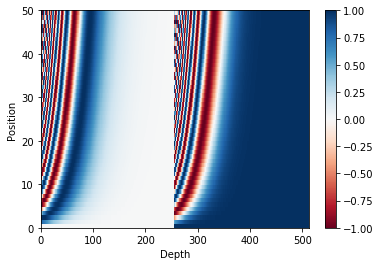

In [13]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show() # 在这里左右边分别为原来2i 和 2i+1的特征

## 3.掩码
为了避免输入中padding的token对句子语义的影响，需要将padding位mark掉，原来为0的padding项的mark输出为1



In [14]:
def create_padding_mark(seq):
    # 获取为0的padding项
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # 扩充维度以便用于attention矩阵
    return seq[:, np.newaxis, np.newaxis, :] # (batch_size,1,1,seq_len)

# mark 测试
create_padding_mark([[1,2,0,0,3],[3,4,5,0,0]])



<tf.Tensor: id=311819, shape=(2, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]]], dtype=float32)>

look-ahead mask 用于对未预测的token进行掩码
这意味着要预测第三个单词，只会使用第一个和第二个单词。 要预测第四个单词，仅使用第一个，第二个和第三个单词，依此类推。

In [15]:
def create_look_ahead_mark(size):
    # 1 - 对角线和取下三角的全部对角线（-1->全部）
    # 这样就可以构造出每个时刻未预测token的掩码
    mark = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mark  # (seq_len, seq_len)

In [16]:
# x = tf.random.uniform((1,3))
temp = create_look_ahead_mark(3)
print(temp)

tf.Tensor(
[[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)


## 4.Scaled dot product attention
![](https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png)
进行attention计算的时候有3个输入 Q (query), K (key), V (value)。计算公式如下：
$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$


点积注意力通过深度d_k的平方根进行缩放,因为较大的深度会使点积变大，由于使用softmax，会使梯度变小。
例如，考虑Q和K的均值为0且方差为1.它们的矩阵乘法的均值为0，方差为dk。我们使用dk的根用于缩放（而不是任何其他数字），因为Q和K的matmul应该具有0的均值和1的方差。

在这里我们将被掩码的token乘以-1e9(表示负无穷),这样softmax之后就为0,不对其他token产生影响。

In [17]:
def scaled_dot_product_attention(q, k, v, mask):
    # query key 相乘获取匹配关系
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    # 使用dk进行缩放
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # 掩码
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    # 通过softmax获取attention权重
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    # attention 乘上value
    output = tf.matmul(attention_weights, v) # （.., seq_len_v, depth）
    
    return output, attention_weights
    
    

使用attention获取需要关注的语义

In [18]:
def print_out(q, k, v):
    temp_out, temp_att = scaled_dot_product_attention(
    q, k, v, None)
    print('attention weight:')
    print(temp_att)
    print('output:')
    print(temp_out)

attention测试

In [19]:
# 显示为numpy类型
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 3)
# 关注第2个key, 返回对应的value
temp_q = tf.constant([[0,10,0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

attention weight:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
output:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [20]:
# 关注重复的key(第3、4个), 返回对应的value（平均）
temp_q = tf.constant([[0,0,10]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

attention weight:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
output:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [21]:
# 关注第1、2个key, 返回对应的value（平均）
temp_q = tf.constant([[10,10,0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

attention weight:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
output:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [22]:
# 依次放入每个query
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

attention weight:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
output:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## 5.Mutil-Head Attention
![](https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png)

mutil-head attention包含3部分：
- 线性层与分头
- 缩放点积注意力
- 头连接
- 末尾线性层

每个多头注意块有三个输入; Q（查询），K（密钥），V（值）。 它们通过第一层线性层并分成多个头。

注意:点积注意力时需要使用mask， 多头输出需要使用tf.transpose调整各维度。

Q，K和V不是一个单独的注意头，而是分成多个头，因为它允许模型共同参与来自不同表征空间的不同信息。 在拆分之后，每个头部具有降低的维度，总计算成本与具有全维度的单个头部注意力相同。

In [23]:
# 构造mutil head attention层
class MutilHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MutilHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        # d_model 必须可以正确分为各个头
        assert d_model % num_heads == 0
        # 分头后的维度
        self.depth = d_model // num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        # 分头, 将头个数的维度 放到 seq_len 前面
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        # 分头前的前向网络，获取q、k、v语义
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)
        v = self.wv(v)
        
        # 分头
        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_v, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        
        # 通过缩放点积注意力层
        scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
        # 把多头维度后移
        scaled_attention = tf.transpose(scaled_attention, [0, 2, 1, 3]) # (batch_size, seq_len_v, num_heads, depth)

        # 合并多头
        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))
        
        # 全连接重塑
        output = self.dense(concat_attention)
        return output, attention_weights
        
        
        
        

测试多头attention

In [24]:
temp_mha = MutilHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))
output, att = temp_mha(y, k=y, q=y, mask=None)
print(output.shape, att.shape)

(1, 60, 512) (1, 8, 60, 60)


point wise前向网络

In [25]:
def point_wise_feed_forward_network(d_model, diff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(diff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [26]:
sample_fnn = point_wise_feed_forward_network(512, 2048)
sample_fnn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## 6.编码器和解码器

![](https://www.tensorflow.org/images/tutorials/transformer/transformer.png)

- 通过N个编码器层，为序列中的每个字/令牌生成输出。
- 解码器连接编码器的输出和它自己的输入（自我注意）以预测下一个字。

### 编码层
每个编码层包含以下子层
- Multi-head attention（带掩码）
- Point wise feed forward networks

每个子层中都有残差连接，并最后通过一个正则化层。残差连接有助于避免深度网络中的梯度消失问题。
每个子层输出是LayerNorm(x + Sublayer(x))，规范化是在d_model维的向量上。Transformer一共有n个编码层。



In [27]:
class LayerNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-6, **kwargs):
        self.eps = epsilon
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=tf.ones_initializer(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=tf.zeros_initializer(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = tf.keras.backend.mean(x, axis=-1, keepdims=True)
        std = tf.keras.backend.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

In [28]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, ddf, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MutilHeadAttention(d_model, n_heads)
        self.ffn = point_wise_feed_forward_network(d_model, ddf)
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, inputs, training, mask):
        # 多头注意力网络
        att_output, _ = self.mha(inputs, inputs, inputs, mask)
        att_output = self.dropout1(att_output, training=training)
        out1 = self.layernorm1(inputs + att_output)  # (batch_size, input_seq_len, d_model)
        # 前向网络
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2
    
    

encoder层测试

In [29]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_encoder_layer_output = sample_encoder_layer(
tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

### 解码层

每个编码层包含以下子层：
- Masked muti-head attention（带padding掩码和look-ahead掩码）
- Muti-head attention（带padding掩码）value和key来自encoder输出，query来自Masked muti-head attention层输出
- Point wise feed forward network

每个子层中都有残差连接，并最后通过一个正则化层。残差连接有助于避免深度网络中的梯度消失问题。

每个子层输出是LayerNorm(x + Sublayer(x))，规范化是在d_model维的向量上。Transformer一共有n个解码层。

当Q从解码器的第一个注意块接收输出，并且K接收编码器输出时，注意权重表示基于编码器输出给予解码器输入的重要性。 换句话说，解码器通过查看编码器输出并自我关注其自己的输出来预测下一个字。

ps：因为padding在后面所以look-ahead掩码同时掩padding


In [30]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, drop_rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MutilHeadAttention(d_model, num_heads)
        self.mha2 = MutilHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(drop_rate)
        self.dropout2 = layers.Dropout(drop_rate)
        self.dropout3 = layers.Dropout(drop_rate)
        
    def call(self,inputs, encode_out, training, 
             look_ahead_mask, padding_mask):
        # masked muti-head attention
        att1, att_weight1 = self.mha1(inputs, inputs, inputs,look_ahead_mask)
        att1 = self.dropout1(att1, training=training)
        out1 = self.layernorm1(inputs + att1)
        # muti-head attention
        att2, att_weight2 = self.mha2(encode_out, encode_out, inputs, padding_mask)
        att2 = self.dropout2(att2, training=training)
        out2 = self.layernorm2(out1 + att2)
        
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out, training=training)
        out3 = self.layernorm3(out2 + ffn_out)
        
        return out3, att_weight1, att_weight2
        
        
        
        
        

测试解码层

In [31]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)
sample_decoder_layer_output.shape

TensorShape([64, 50, 512])

### 编码器

编码器包含：
- Input Embedding
- Positional Embedding
- N个编码层



In [32]:
class Encoder(layers.Layer):
    def __init__(self, n_layers, d_model, n_heads, ddf,
                input_vocab_size, max_seq_len, drop_rate=0.1):
        super(Encoder, self).__init__()
        
        self.n_layers = n_layers
        self.d_model = d_model
        
        self.embedding = layers.Embedding(input_vocab_size, d_model)
        self.pos_embedding = positional_encoding(max_seq_len, d_model)
        
        self.encode_layer = [EncoderLayer(d_model, n_heads, ddf, drop_rate)
                            for _ in range(n_layers)]
        
        self.dropout = layers.Dropout(drop_rate)
    def call(self, inputs, training, mark):
        
        seq_len = inputs.shape[1]
        word_emb = self.embedding(inputs)
        word_emb *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        emb = word_emb + self.pos_embedding[:,:seq_len,:]
        x = self.dropout(emb, training=training)
        for i in range(self.n_layers):
            x = self.encode_layer[i](x, training, mark)
        
        return x
            

编码器测试

In [33]:
sample_encoder = Encoder(2, 512, 8, 1024, 5000, 200)
sample_encoder_output = sample_encoder(tf.random.uniform((64, 120)),
                                      False, None)
sample_encoder_output.shape

TensorShape([64, 120, 512])

### 解码器
解码器包含以下部分：1、输出嵌入；2、位置编码；3、n个解码层

输出嵌入和位置编码叠加后输入解码器，解码器最后的输出送给一个全连接

In [34]:
# import pdb
# pdb.set_trace()
class Decoder(layers.Layer):
    def __init__(self, n_layers, d_model, n_heads, ddf,
                target_vocab_size, max_seq_len, drop_rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.n_layers = n_layers
        
        self.embedding = layers.Embedding(target_vocab_size, d_model)
        self.pos_embedding = positional_encoding(max_seq_len, d_model)
        
        self.decoder_layers= [DecoderLayer(d_model, n_heads, ddf, drop_rate)
                             for _ in range(n_layers)]
        
        self.dropout = layers.Dropout(drop_rate)
        
    def call(self, inputs, encoder_out,training,
             look_ahead_mark, padding_mark):
    
        seq_len = tf.shape(inputs)[1]
        attention_weights = {}
        h = self.embedding(inputs)
        h *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        h += self.pos_embedding[:,:seq_len,:]
        
        h = self.dropout(h, training=training)
#         print('--------------------\n',h, h.shape)
        # 叠加解码层
        for i in range(self.n_layers):
            h, att_w1, att_w2 = self.decoder_layers[i](h, encoder_out,
                                                   training, look_ahead_mark,
                                                   padding_mark)
            attention_weights['decoder_layer{}_att_w1'.format(i+1)] = att_w1
            attention_weights['decoder_layer{}_att_w2'.format(i+1)] = att_w2
        
        return h, attention_weights
    


解码器测试

In [35]:


sample_decoder = Decoder(2, 512,8,1024,5000, 200)
sample_decoder_output, attn = sample_decoder(tf.random.uniform((64, 100)),
                                            sample_encoder_output, False,
                                            None, None)
sample_decoder_output.shape, attn['decoder_layer1_att_w1'].shape

(TensorShape([64, 100, 512]), TensorShape([64, 8, 100, 100]))

### 创建Transformer
Transformer包含编码器、解码器和最后的线性层，解码层的输出经过线性层后得到Transformer的输出


In [36]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, diff,
                input_vocab_size, target_vocab_size,
                max_seq_len, drop_rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(n_layers, d_model, n_heads,diff,
                              input_vocab_size, max_seq_len, drop_rate)
        
        self.decoder = Decoder(n_layers, d_model, n_heads, diff,
                              target_vocab_size, max_seq_len, drop_rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    def call(self, inputs, targets, training, encode_padding_mask, 
            look_ahead_mask, decode_padding_mask):
        
        encode_out = self.encoder(inputs, training, encode_padding_mask)
        print(encode_out.shape)
        decode_out, att_weights = self.decoder(targets, encode_out, training, 
                                               look_ahead_mask, decode_padding_mask)
        print(decode_out.shape)
        final_out = self.final_layer(decode_out)
        
        return final_out, att_weights
        
        
    

Transformer测试

In [37]:
sample_transformer = Transformer(
n_layers=2, d_model=512, n_heads=8, diff=1024,
input_vocab_size=8500, target_vocab_size=8000, max_seq_len=120
)
temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))
fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                              encode_padding_mask=None,
                               look_ahead_mask=None,
                               decode_padding_mask=None,
                              )
fn_out.shape

(64, 62, 512)
(64, 26, 512)


TensorShape([64, 26, 8000])

## 7.实验设置
### 设置超参



In [38]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
max_seq_len = 40
dropout_rate = 0.1

### 优化器
带自定义学习率调整的Adam优化器
$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [39]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    


In [40]:
learing_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learing_rate, beta_1=0.9, 
                                    beta_2=0.98, epsilon=1e-9)

Text(0, 0.5, 'train step')

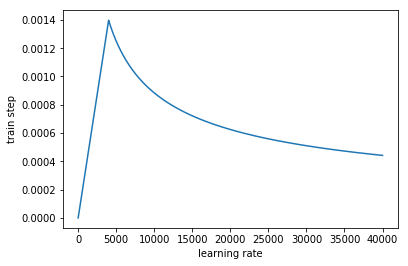

In [41]:
# 测试
temp_learing_rate = CustomSchedule(d_model)
plt.plot(temp_learing_rate(tf.range(40000, dtype=tf.float32)))
plt.xlabel('learning rate')
plt.ylabel('train step')

### 损失和指标
由于目标序列是填充的，因此在计算损耗时应用填充掩码很重要。
padding的掩码为0，没padding的掩码为1


In [42]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                           reduction='none')

def loss_fun(y_ture, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_ture, 0))  # 为0掩码标1
    loss_ = loss_object(y_ture, y_pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [43]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')


## 8、训练和保持模型

In [44]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          max_seq_len, dropout_rate)


In [45]:
# 构建掩码
def create_mask(inputs,targets):
    encode_padding_mask = create_padding_mark(inputs)
    # 这个掩码用于掩输入解码层第二层的编码层输出
    decode_padding_mask = create_padding_mark(inputs)
    
    # look_ahead 掩码， 掩掉未预测的词
    look_ahead_mask = create_look_ahead_mark(tf.shape(targets)[1])
    # 解码层第一层得到padding掩码
    decode_targets_padding_mask = create_padding_mark(targets)
    
    # 合并解码层第一层掩码
    combine_mask = tf.maximum(decode_targets_padding_mask, look_ahead_mask)
    
    return encode_padding_mask, combine_mask, decode_padding_mask


    
    
    
    

创建checkpoint管理器

In [46]:
checkpoint_path = './checkpoint/train'
ckpt = tf.train.Checkpoint(transformer=transformer,
                          optimizer=optimizer)
# ckpt管理器
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('last checkpoit restore')


target分为target_input和target real.
target_input是传给解码器的输入，target_real是其左移一个位置的结果，每个target_input位置对应下一个预测的标签

如句子=“SOS A丛林中的狮子正在睡觉EOS”

target_input =“SOS丛林中的狮子正在睡觉”

target_real =“丛林中的狮子正在睡觉EOS”

transformer是个自动回归模型：它一次预测一个部分，并使用其到目前为止的输出，决定下一步做什么。

在训练期间使用teacher-forcing，即无论模型当前输出什么都强制将正确输出传给下一步。

而预测时则根据前一个的输出预测下一个词

为防止模型在预期输出处达到峰值，模型使用look-ahead mask

In [47]:
@tf.function
def train_step(inputs, targets):
    tar_inp = targets[:,:-1]
    tar_real = targets[:,1:]
    # 构造掩码
    encode_padding_mask, combined_mask, decode_padding_mask = create_mask(inputs, tar_inp)
    
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inputs, tar_inp,
                                    True,
                                    encode_padding_mask,
                                    combined_mask,
                                    decode_padding_mask)
        loss = loss_fun(tar_real, predictions)
    # 求梯度
    gradients = tape.gradient(loss, transformer.trainable_variables)
    # 反向传播
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    # 记录loss和准确率
    train_loss(loss)
    train_accuracy(tar_real, predictions)
    

    

葡萄牙语用作输入语言，英语是目标语言。

In [48]:
EPOCHS = 20
for epoch in range(EPOCHS):
    start = time.time()
    
    # 重置记录项
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    # inputs 葡萄牙语， targets英语
    
    for batch, (inputs, targets) in enumerate(train_dataset):
        # 训练
        train_step(inputs, targets)
        
        if batch % 500 == 0:
            print('epoch {}, batch {}, loss:{:.4f}, acc:{:.4f}'.format(
            epoch+1, batch, train_loss.result(), train_accuracy.result()
            ))
            
    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('epoch {}, save model at {}'.format(
        epoch+1, ckpt_save_path
        ))
    
    
    print('epoch {}, loss:{:.4f}, acc:{:.4f}'.format(
    epoch+1, train_loss.result(), train_accuracy.result()
    ))
    
    print('time in 1 epoch:{} secs\n'.format(time.time()-start))
        
        
    

(64, 40, 128)
(64, 39, 128)
(64, 40, 128)
(64, 39, 128)
epoch 1, batch 0, loss:4.0259, acc:0.0000
epoch 1, batch 500, loss:3.4436, acc:0.0340
(31, 40, 128)
(31, 39, 128)
epoch 1, loss:3.2112, acc:0.0481
time in 1 epoch:467.3876633644104 secs

epoch 2, batch 0, loss:2.4443, acc:0.0982
epoch 2, batch 500, loss:2.3006, acc:0.1139
epoch 2, save model at ./checkpoint/train/ckpt-1
epoch 2, loss:2.2473, acc:0.1184
time in 1 epoch:429.6356120109558 secs

epoch 3, batch 0, loss:2.0709, acc:0.1306
epoch 3, batch 500, loss:2.0279, acc:0.1412
epoch 3, loss:1.9927, acc:0.1443
time in 1 epoch:426.3838963508606 secs

epoch 4, batch 0, loss:1.8720, acc:0.1571
epoch 4, batch 500, loss:1.8020, acc:0.1678
epoch 4, save model at ./checkpoint/train/ckpt-2
epoch 4, loss:1.7664, acc:0.1714
time in 1 epoch:387.37333059310913 secs

epoch 5, batch 0, loss:1.6616, acc:0.1807
epoch 5, batch 500, loss:1.5908, acc:0.1936
epoch 5, loss:1.5610, acc:0.1961
time in 1 epoch:389.60524225234985 secs

epoch 6, batch 0, los